Classes encontradas: ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'] (total=6)
Linhas no train.csv: 18632

Valores ausentes por coluna:


image          0
labels         0
labels_list    0
y              0
dtype: int64

,count
complex,2151
frog_eye_leaf_spot,4352
healthy,4624
powdery_mildew,1271
rust,2077
scab,5712



Distribuição de nº de rótulos por imagem:


,num_imagens
n_labels,
1,17277
2,1155
3,200


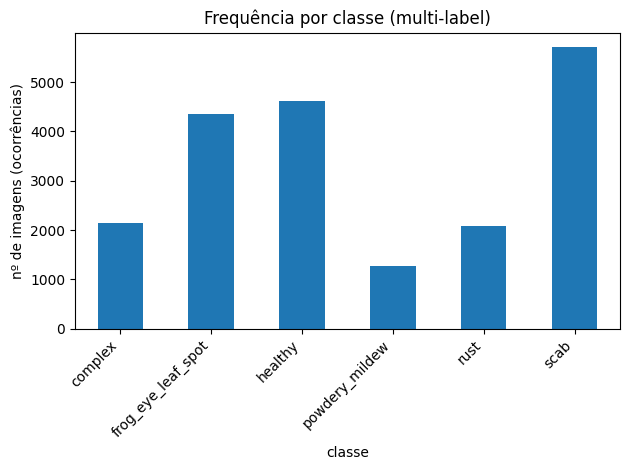

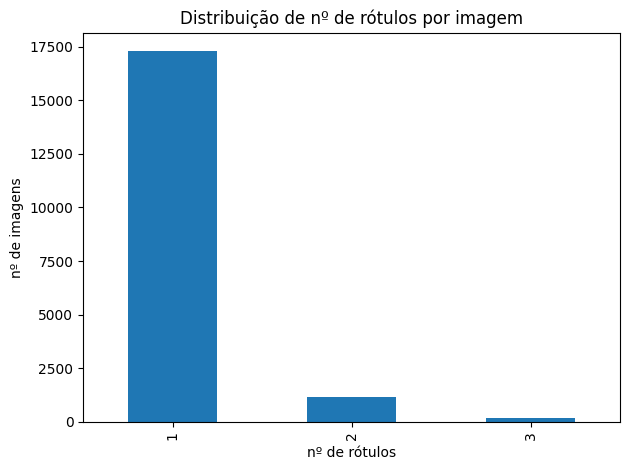


Amostras de imagens 3 por classe:


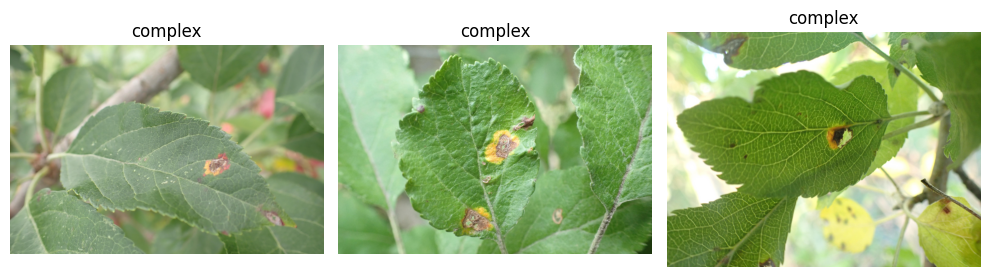

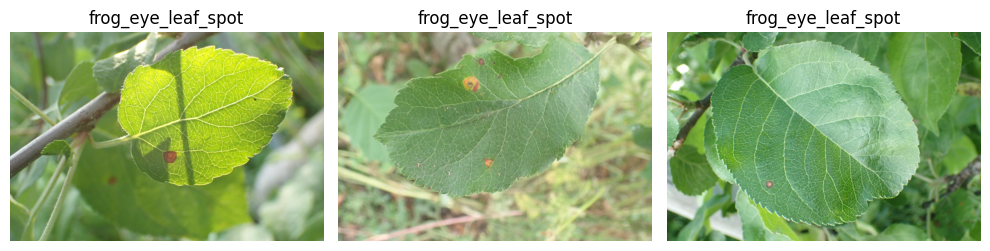

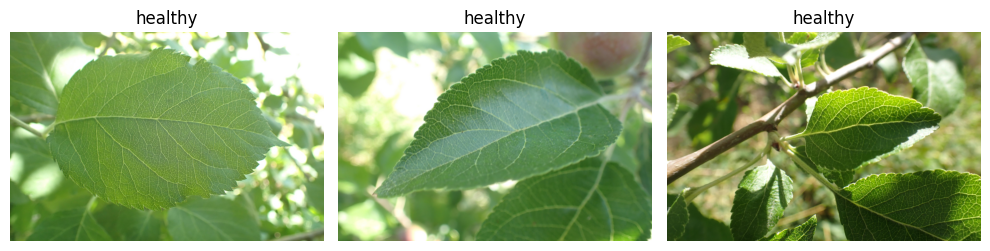

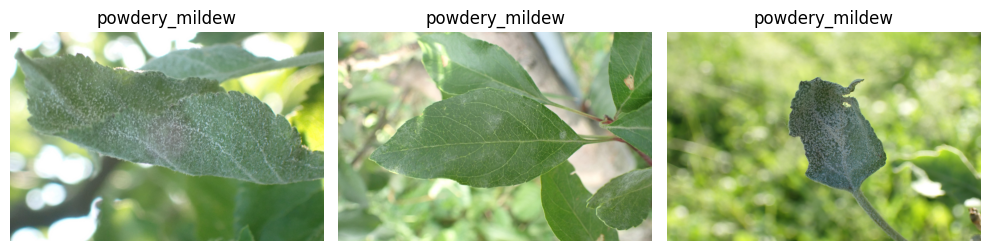

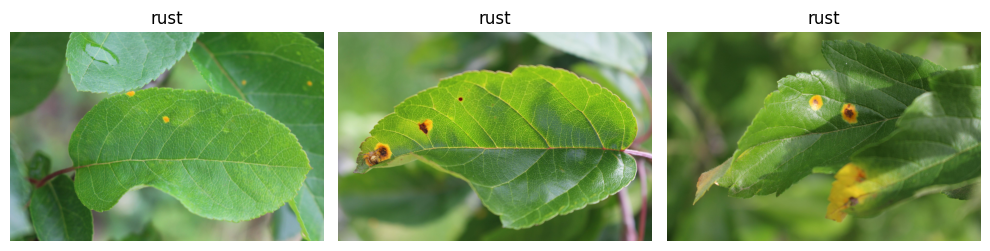

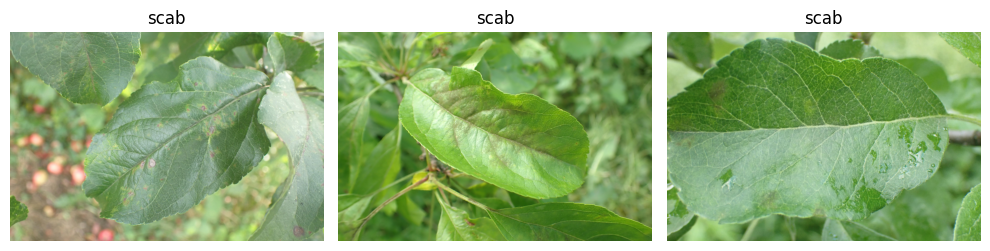


✅ EDA concluída.


In [4]:
# ===============================
# Notebook 01 — EDA (Plant Pathology) [Versão Simplificada + Sinopses]
# ===============================

# 0) Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1) Caminhos
DATA_DIR = Path("../data")  # ajuste se necessário
TRAIN_CSV = DATA_DIR / "train.csv"
TRAIN_DIR = DATA_DIR / "train_images"
TEST_DIR  = DATA_DIR / "test_images"

assert TRAIN_CSV.exists(), f"train.csv não encontrado em {TRAIN_CSV}"
assert TRAIN_DIR.exists(), f"train_images/ não encontrado em {TRAIN_DIR}"

# 2) Carregar rótulos
df = pd.read_csv(TRAIN_CSV)
df.columns = [c.strip().lower() for c in df.columns]  # garante 'image' e 'labels'
assert {"image", "labels"} <= set(df.columns), "train.csv precisa conter colunas 'image' e 'labels'"

# 3) Processar multi-rótulo
df["labels_list"] = df["labels"].astype(str).str.strip().str.split()
all_labels = sorted({lab for labs in df["labels_list"] for lab in labs})
label2idx = {lab:i for i, lab in enumerate(all_labels)}

def encode_multi_hot(labs):
    v = np.zeros(len(all_labels), dtype=np.float32)
    for lab in labs:
        if lab in label2idx:
            v[label2idx[lab]] = 1.0
    return v

df["y"] = df["labels_list"].apply(encode_multi_hot)
Y = np.stack(df["y"].values)
print("Classes encontradas:", all_labels, f"(total={len(all_labels)})")
print("Linhas no train.csv:", len(df))

# 4) Estatísticas descritivas (adaptadas)
# 4.4) Checar valores ausentes
print("\nValores ausentes por coluna:")
display(df.isna().sum())

# 4.1) Contagem por classe (multi-label)
cnt = Counter(l for labs in df["labels_list"] for l in labs)
class_freq = pd.Series(cnt).reindex(all_labels).fillna(0).astype(int)
display(class_freq.to_frame("count"))
# >>> Interpretação: mostra se o dataset está balanceado ou não. 
#     Exemplo: 'healthy' e 'scab' têm mais imagens, enquanto 'powdery_mildew' é bem menor → pode gerar desbalanceamento.

# 4.2) Quantidade de rótulos por imagem
df["n_labels"] = df["labels_list"].apply(len)
label_cardinality = df["n_labels"].value_counts().sort_index()
print("\nDistribuição de nº de rótulos por imagem:")
display(label_cardinality.to_frame("num_imagens"))
# >>> Interpretação: a maioria das imagens tem apenas 1 doença, 
#     mas existe um grupo relevante com 2 ou 3 doenças → problema é multi-label, não só multi-class.

# 5) Visualizações
# 5.1) Histograma — frequência por classe
plt.figure()
class_freq.plot(kind="bar")
plt.title("Frequência por classe (multi-label)")
plt.ylabel("nº de imagens (ocorrências)")
plt.xlabel("classe")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
# >>> Interpretação: confirma visualmente o desbalanceamento (scab/healthy dominam).

# 5.2) Histograma — nº de rótulos por imagem
plt.figure()
label_cardinality.sort_index().plot(kind="bar")
plt.title("Distribuição de nº de rótulos por imagem")
plt.xlabel("nº de rótulos")
plt.ylabel("nº de imagens")
plt.tight_layout()
plt.show()
# >>> Interpretação: valida que grande parte é 1 rótulo, mas casos multi-label são relevantes → modelo precisa prever mais de uma doença.

# 6) Amostras de imagens por classe
def show_examples(label, n=6):
    subset = df[df["labels"].str.contains(rf"\b{label}\b", regex=True, na=False)]
    if subset.empty:
        print(f"[Aviso] Sem imagens para a classe '{label}'.")
        return
    samples = subset.sample(min(n, len(subset)), random_state=42)["image"].tolist()
    cols = 3
    rows = int(np.ceil(len(samples)/cols))
    plt.figure(figsize=(10, 3.5*rows))
    for i, img_name in enumerate(samples, 1):
        p = TRAIN_DIR / img_name
        try:
            im = plt.imread(p)
            plt.subplot(rows, cols, i)
            plt.imshow(im)
            plt.title(label)
            plt.axis('off')
        except Exception as e:
            print(f"Falha ao abrir {p}: {e}")
    plt.tight_layout()
    plt.show()

print("\nAmostras de imagens 3 por classe:")
for lab in all_labels:
    show_examples(lab, n=3)
# >>> Interpretação: imagens ilustram diferenças visuais entre classes (manchas, cores, texturas). 
#     Justifica uso de CNN/Visão Computacional.

print("\n✅ EDA concluída.")
